# Image Segmentation Task 2

In [ ]:
!python -m pip install cityscapesscripts

### Imports

In [3]:
import os
import torch
import random
import numpy as np

from os.path import join as pjoin
from datasets.cityscapes import cityscapesDataset

### Setup

In [4]:
# reproducibility setups
torch.manual_seed(253452757)
random.seed(253452757)
np.random.seed(253452757)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="2" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

### Hyperparameters

In [6]:
local_path = "./Cityscapes"
bs = 5
epochs = 15
learning_rate = 0.0002
patience = 10

### Dataset and Dataloader

In [7]:
training_data = cityscapesDataset(local_path, split="train")
training_data_raw = cityscapesDataset(local_path, split="train", is_transform=False)
validation_data = cityscapesDataset(local_path, split="val")
test_data = cityscapesDataset(local_path, split="test")

Annotations files processed
Annotations files processed
Annotations files processed
Annotations files processed


In [8]:
dataloaders = {
    'train' : torch.utils.data.DataLoader(training_data, batch_size=bs, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(validation_data, batch_size=bs, shuffle=True, num_workers=0)
}

In [9]:
dataset_sizes = {
    'train': len(training_data),
    'val': len(validation_data),
    'test': len(test_data),
    'total': len(training_data) + len(validation_data) + len(test_data)
}

dataset_sizes

{'train': 2975, 'val': 500, 'test': 1525, 'total': 5000}

### Model setup

In [11]:
from networks.utils import count_parameters
from networks.r2unet import R2UNet64

In [12]:
model = R2UNet64().to(device)

In [13]:
print("Number of trainable parameters = ", count_parameters(model, only_trainable=True))
print("Number of total parameters = ", count_parameters(model))

Number of trainable parameters =  78472851
Number of total parameters =  78472851


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_f = torch.nn.CrossEntropyLoss(ignore_index = 255)

### Training

In [10]:
import training

In [15]:
model_path = 'models/r2unet64/'
if not os.path.isdir(model_path):
    os.makedirs(model_path)

In [ ]:
model = training.train(model, dataloaders, dataset_sizes, model_path, loss_f, optimizer, epochs)

In [ ]:
checkpoint = torch.load(pjoin(model_path, "epoch-{}.pt".format(epochs-1)))

In [11]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Evaluate the results

In [16]:
import evaluation

In [17]:
true_list = []
pred_list = []
model.eval()
model = model.to(device)

with torch.no_grad():
    for inputs, ground_truths in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        pred_list.append(torch.argmax(outputs.detach().cpu(), dim = 1))
        true_list.append(ground_truths)

true_list = torch.flatten(torch.cat(true_list))
pred_list = torch.flatten(torch.cat(pred_list))

In [18]:
eval_report = evaluation.EvaluationReport.from_predictions(true_list, pred_list, labels=list(range(19)))

In [19]:
eval_report.get_metrics(average="macro")

{'accuracy': 0.9513,
 'sensitivity': 0.2914,
 'specificity': 0.9739,
 'dice_coeff': 0.2535,
 'jaccard_sim': 0.1717,
 'precision': 0.3877,
 'recall': 0.2914,
 'f1_score': 0.2535}

In [20]:
eval_report.get_metrics(average="weighted")

{'accuracy': 0.8812,
 'sensitivity': 0.5376,
 'specificity': 0.9661,
 'dice_coeff': 0.6111,
 'jaccard_sim': 0.4623,
 'precision': 0.7593,
 'recall': 0.5376,
 'f1_score': 0.6111}

In [ ]:
for i in range(19): 
    print("Class {} - {}".format(i, training_data.label_names()[i]))
    class_metrics = eval_report.get_metrics(metrics, pos_label=i)
    for k in class_metrics.keys():
        print(" {} = {}".format(k, class_metrics[k]))
    print()

### Visualize the results

In [12]:
from utils import plot_seg_results

In [13]:
img_size = (512, 256)
init_pic = 123
n_pics = 5

In [14]:
inputs = torch.stack([training_data[i][0] for i in range(init_pic, init_pic + n_pics)])
images = [training_data_raw[i][0].resize(img_size) for i in range(init_pic, init_pic + n_pics)]
ground_truths = torch.stack([training_data[i][1] for i in range(init_pic, init_pic + n_pics)])

In [15]:
outputs = model(inputs.to(device))
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)

In [16]:
predictions = [training_data.decode_segmap(pred.numpy()) for pred in predictions]
ground_truths = [training_data.decode_segmap(gt.numpy()) for gt in ground_truths]

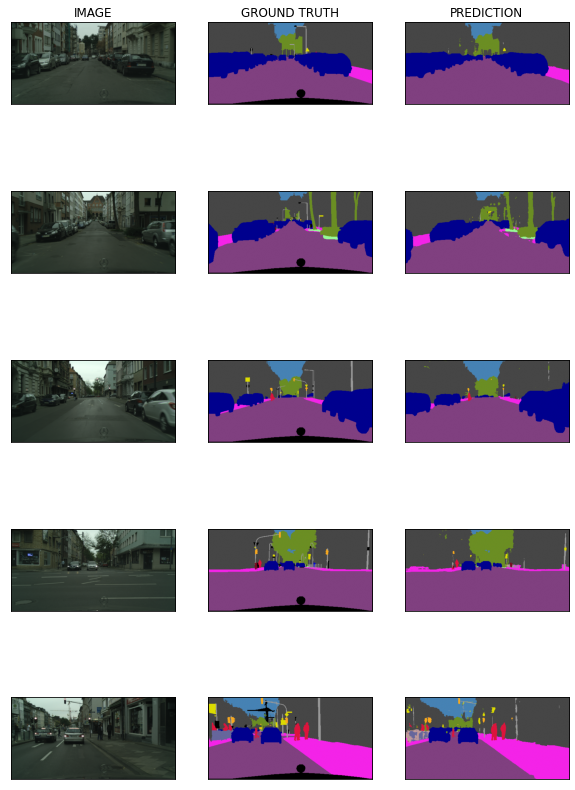

In [17]:
plot_seg_results(images, ground_truths, predictions)